# Universal differential equation for SIR ODE model

In this notebook, we want to regularize the UDE training to prevent the neural network from absorbing the effect of the mechanistic model, thus ensuring that the mechanistic parameter can be correctly estimated.

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behavior
rng = StableRNG(1);

### 1. Define the SIR model and sample one data set

In [2]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ode = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0)

prob = ODEProblem(sir!, u0, tspan, p_ode)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

In [3]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.05)
noise = rand(rng, dist, size(X[:, begin:4:end]))
X_noisy = noise .* X[:, begin:4:end];

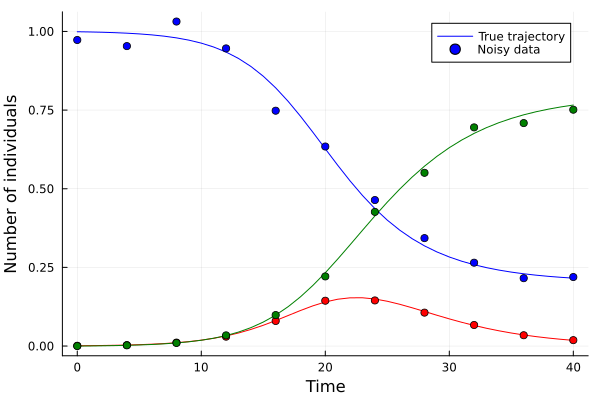

In [4]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals",
     color = [:blue :red :green], label = ["True trajectory" nothing nothing])
scatter!(t[begin:4:end], X_noisy', color = [:blue :red :green], label = ["Noisy data" nothing nothing])

### 2. Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u, \gamma)+\text{NN}(u, \theta)$.

In [5]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))

# Multi-layer feed-forward neural network
model = Chain(Dense(3, 5, rbf), Dense(5, 5, rbf), Dense(5, 5, rbf), Dense(5, 3))

# Get initial parameters and state variables of the model
θ_init, st = Lux.setup(rng, model);

In [6]:
# Define the hybrid model
function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p.nn, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = -p.γ*u[2] + nn[2] 
    du[3] = p.γ*u[2] + nn[3]
end

γ_init = 0.1
p_init = (nn = θ_init, γ = γ_init)
p_init = ComponentVector(p_init)
prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### 3. Set up the training

In [7]:
function predict(p, saveat = t[begin:4:end])   # p contains NN parameters θ and mechanistic parameter γ of the ODE
    _prob = remake(prob_ude, p = p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = saveat,
                sensealg = QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [8]:
function loss(x, p)   # x: optimized variable, p: parametrization of the objective
    X̂ = predict(x)
    if p.reg == nothing
        mean(abs2, X_noisy .- X̂)   
    elseif p.reg == "L2 NN parameter"
        mean(abs2, X_noisy .- X̂) + p.α * norm(x.nn)
    elseif p.reg == "L2 NN output"
        mean(abs2, X_noisy .- X̂) + p.α * norm(Lux.apply(model, X_noisy, x.nn, st)[1]) ### TODO
    elseif p.reg == "Integral"
        mean(abs2, X_noisy .- X̂) ### TODO
    end
end;

### 4. Method to train the UDE using different regularization techniques

In [9]:
function train_ude(reg, α, adam_epochs = 8000, bfgs_epochs = 2000)
    # Set up loss history
    losses = Float64[]
    function callback(p, l)
        push!(losses, l)
        n_iter = length(losses)
        if n_iter % 250 == 0   
            println("Loss after $(n_iter) iterations: $(losses[end])")
        end
        return false
    end
    
    # Set up optimization problem
    adtype = AutoZygote()
    optf = OptimizationFunction(loss, adtype)
    optprob = OptimizationProblem(optf, p_init, (reg = reg, α = α))
    
    # Hybrid training procedure combining Adam and BFGS
    println("Using Adam:")
    res1 = solve(optprob, ADAM(), callback = callback, maxiters = adam_epochs)
    optprob2 = OptimizationProblem(optf, res1.u, (reg = reg, α = α))
    println("Using BFGS:")
    res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = bfgs_epochs)
    p_trained = res2.u;
    
    return [reg, α, adam_epochs, losses, p_trained]    
end;    

### 5. Method to visualize the results

In [10]:
function visualize(result)  
    # Unpack result
    reg, α, adam_epochs, losses, p_trained = result    
    
    # Print estimated mechanistic parameter
    println("Regularization: $(reg), α: $(α)")
    println("Estimate of γ: $(p_trained.γ)")
    
    # Convergence plot
    p1 = plot(1:adam_epochs, losses[1:adam_epochs], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM",
              color=:blue)
    plot!(adam_epochs+1:length(losses), losses[adam_epochs+1:end], yaxis=:log10, label="BFGS", color=:red)
    
    # Data fit
    X̂ = predict(p_trained, t)
    p2 = plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :red :green],
              label = ["UDE approximation" nothing nothing])
    scatter!(t[begin:4:end], X_noisy', color = [:blue :red :green], label = ["Noisy data" nothing nothing])
    
    # Approximation of true trajectory
    p3 = plot(t, X', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :red :green], 
              label = ["True trajectory" nothing nothing])
    plot!(t, X̂', linestyle = :dash, color = [:blue :red :green], label = ["UDE approximation" nothing nothing])
    
    # True residual dynamics (i.e. interactions of predictors) along the true trajectory
    dynamics_true = [-p_ode[1]/p_ode[3] * (X[1, :] .* X[2, :])'; p_ode[1]/p_ode[3] * (X[1, :] .* X[2, :])'; 
                     zeros(length(t))']
    # Neural network guess along the true trajectory
    dynamics_nn = Lux.apply(model, X, p_trained.nn, st)[1]
    # Compare true and learned residual dynamics
    p4 = plot(t, dynamics_true', xlabel = "Time", ylabel = "Residual dynamics", color = [:blue :red :green], 
              label = ["True" nothing nothing])
    plot!(t, dynamics_nn', color = [:blue :red :green], linestyle = :dash, label = ["NN(S,I,R)" nothing nothing])
    
    # Combined plot
    plot(p1, p2, p3, p4, size=(800,600), layout=(2,2))
end;

### 6. Train UDEs and compare results

In [11]:
result_no_reg = train_ude(nothing, nothing, 5000, 1500);

Using Adam:
Loss after 250 iterations: 19.851104871146436
Loss after 500 iterations: 2.464415882501655
Loss after 750 iterations: 0.353474999915902
Loss after 1000 iterations: 0.05477153627507172
Loss after 1250 iterations: 0.013197470192495567
Loss after 1500 iterations: 0.008752773096913054
Loss after 1750 iterations: 0.008509736301124577
Loss after 2000 iterations: 0.008322482203821759
Loss after 2250 iterations: 0.008129988236269255
Loss after 2500 iterations: 0.007934000437017466
Loss after 2750 iterations: 0.0077358701560272785
Loss after 3000 iterations: 0.007536307687015494
Loss after 3250 iterations: 0.007335356035183443
Loss after 3500 iterations: 0.007132324137003645
Loss after 3750 iterations: 0.006925666796611708
Loss after 4000 iterations: 0.00671282605407876
Loss after 4250 iterations: 0.006490100747272997
Loss after 4500 iterations: 0.0062526140522833245
Loss after 4750 iterations: 0.005994446363822416
Loss after 5000 iterations: 0.005708935867824888
Using BFGS:
Loss af

Regularization: nothing, α: nothing
Estimate of γ: 0.5314725114324588


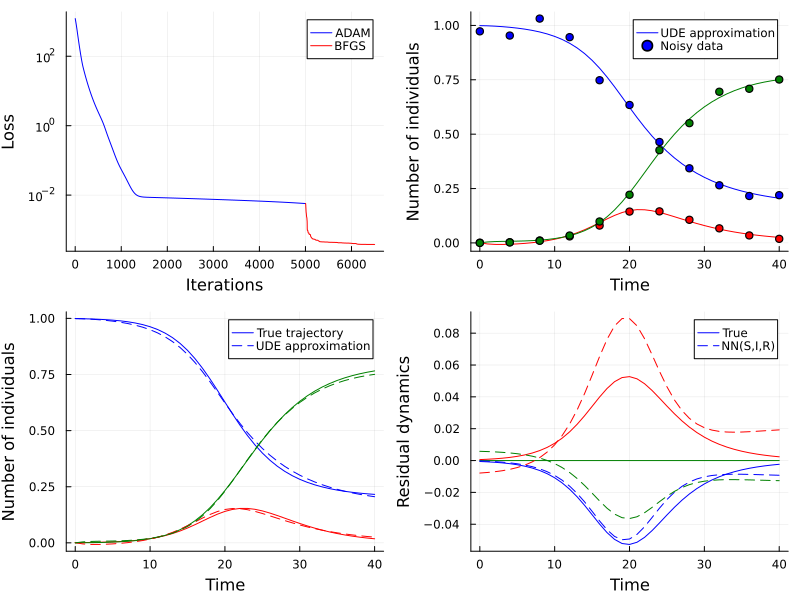

In [12]:
visualize(result_no_reg)

In [13]:
results_L2_NN_param = []

for α in [0.01, 0.005, 0.001, 0.0005, 0.0001]
    push!(results_L2_NN_param, train_ude("L2 NN parameter", α, 5000, 1500)) 
end;

Using Adam:
Loss after 250 iterations: 19.89039126148093
Loss after 500 iterations: 2.504005685510933
Loss after 750 iterations: 0.3928329775433238
Loss after 1000 iterations: 0.09419393327940737
Loss after 1250 iterations: 0.05275829990924231
Loss after 1500 iterations: 0.04832517677111137
Loss after 1750 iterations: 0.048049999141056385
Loss after 2000 iterations: 0.047828871978282984
Loss after 2250 iterations: 0.0476017577962054
Loss after 2500 iterations: 0.04737080837810096
Loss after 2750 iterations: 0.04713775530327604
Loss after 3000 iterations: 0.04690368449133006
Loss after 3250 iterations: 0.04666904496510439
Loss after 3500 iterations: 0.04643360845443054
Loss after 3750 iterations: 0.04619637749373538
Loss after 4000 iterations: 0.04595548932914384
Loss after 4250 iterations: 0.04570818786247704
Loss after 4500 iterations: 0.045450943809565096
Loss after 4750 iterations: 0.04517978998268295
Loss after 5000 iterations: 0.044890849235844466
Using BFGS:
Loss after 5250 itera

Regularization: L2 NN parameter, α: 0.01
Estimate of γ: 0.2494010197311345


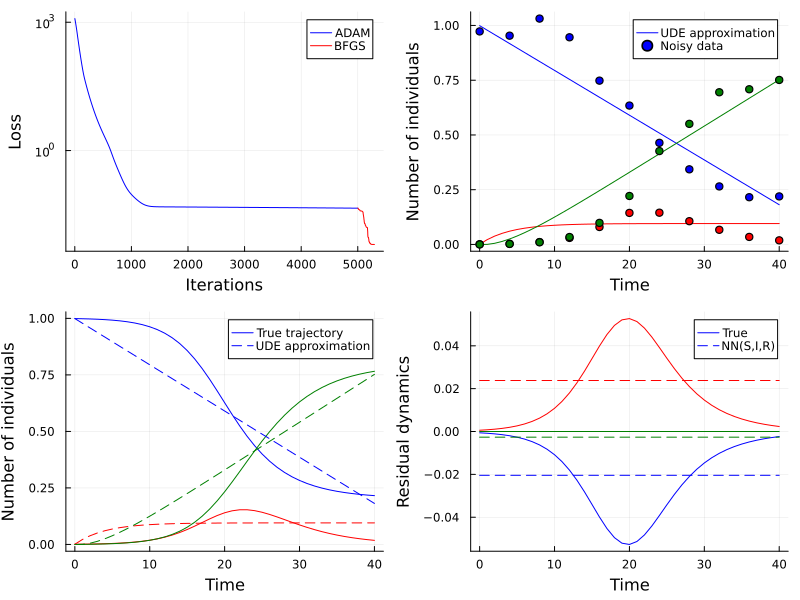

In [14]:
visualize(results_L2_NN_param[1])

Regularization: L2 NN parameter, α: 0.005
Estimate of γ: 0.25821738587422777


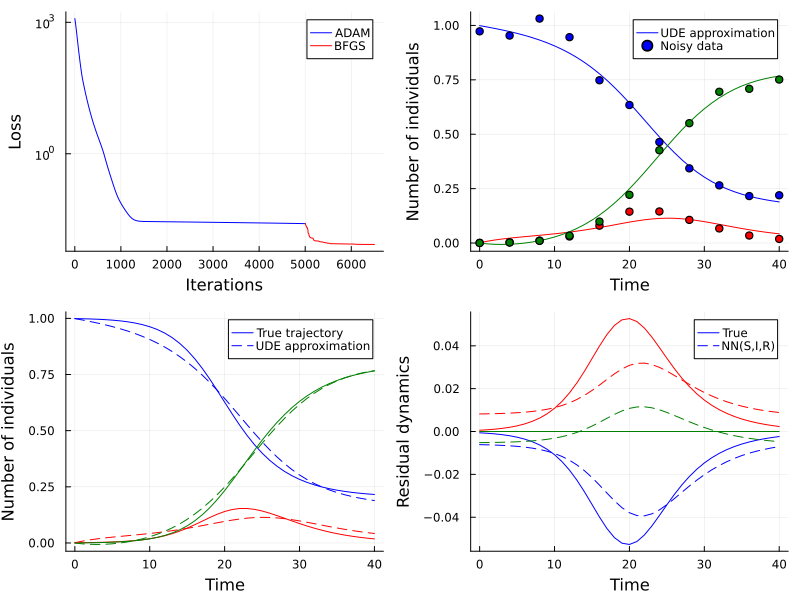

In [15]:
visualize(results_L2_NN_param[2])

Regularization: L2 NN parameter, α: 0.001
Estimate of γ: 0.280774265884865


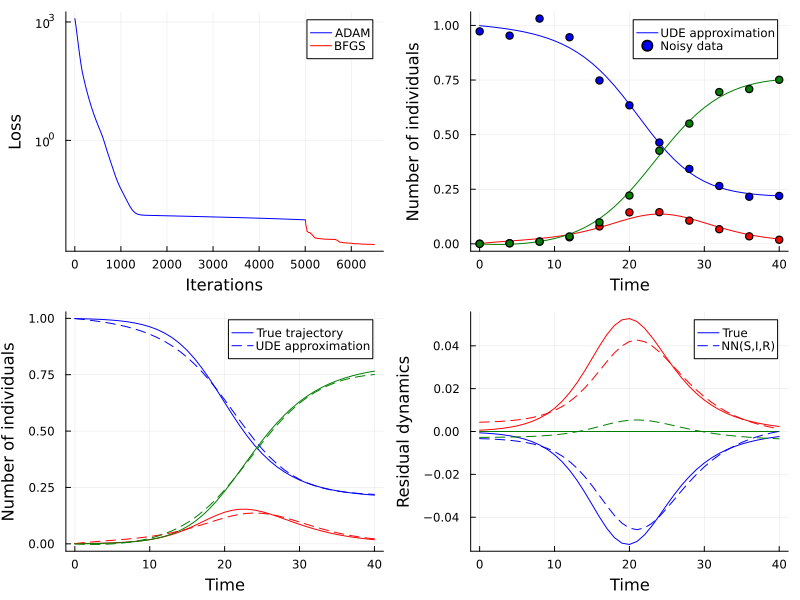

In [16]:
visualize(results_L2_NN_param[3])

Regularization: L2 NN parameter, α: 0.0005
Estimate of γ: 0.3017322975576699


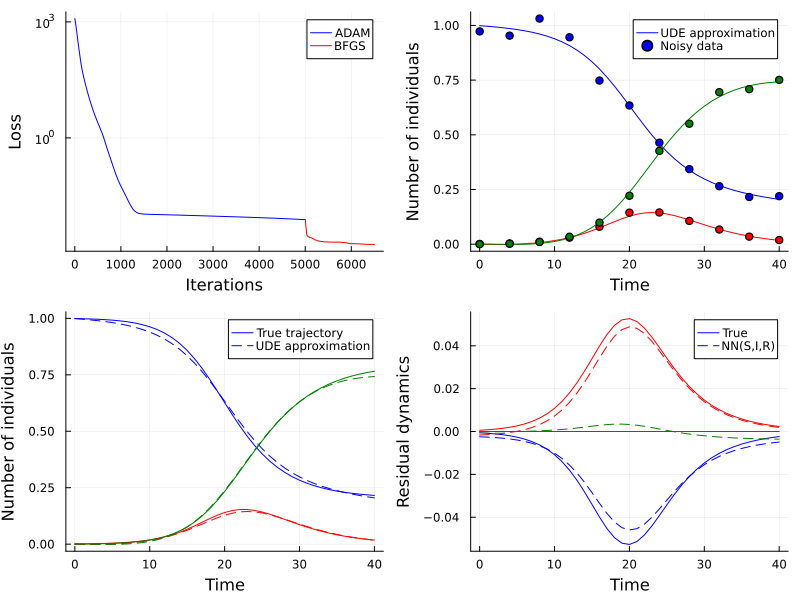

In [17]:
visualize(results_L2_NN_param[4])

Regularization: L2 NN parameter, α: 0.0001
Estimate of γ: 0.3548494814349792


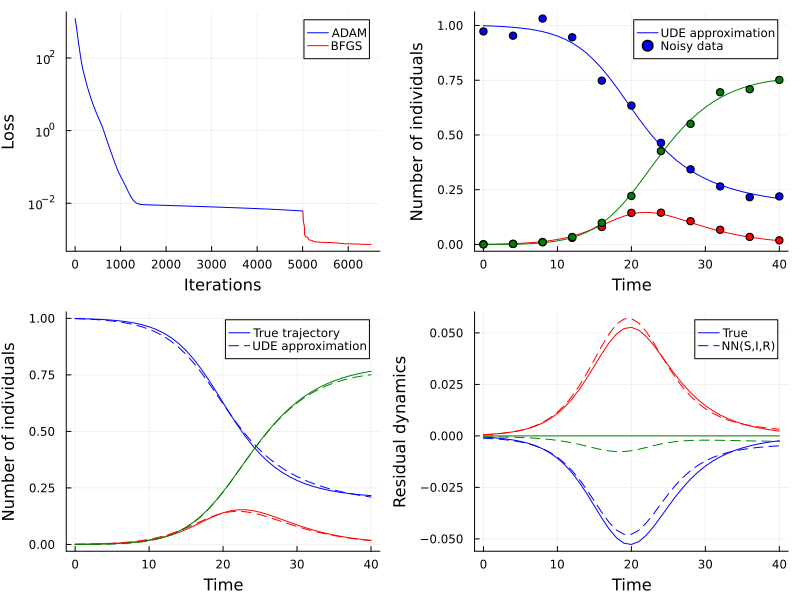

In [18]:
visualize(results_L2_NN_param[5])